In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats
from scipy import interpolate
from glob import glob

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *

In [3]:
# for plotting
plt.rcParams.update({'font.size': 16})

In [101]:
sim_data_dir = '../processed_data/sim'
exp_data_dir = '../processed_data/exp'
exp_meta_data_dir = '../meta_data/exp'

fig_dir = 'Figures/Figure_7'

## Load experimental data

### Spike trains

In [99]:
exp_spike_data_dir = os.path.join(exp_data_dir, 'spikes', 'V1')
filename = 'sessions_spike_counts_-1to0pnt5s_white_flash.npy'

loadpath = os.path.join(exp_spike_data_dir, filename)

sessions_spike_trains_V1 = np.load(loadpath, allow_pickle = True)[()]

## Load simulation data

In [6]:
selected_sims_data_dir = os.path.join(sim_data_dir, 'other_sims_fig7')

In [7]:
nchan_sim = 23           # Number of channels on probe in simulation

trial_dur_sim = 750      # Duration one trial (ms)
tstim_onset_sim = 250    # Stimulus onset in each trial (ms)
ntrials_sim = 10         # Number of trials

### CSD

#### Total CSD

In [22]:
csd_sims_all = find_files(selected_sims_data_dir, filename = 'csd_total*.npy')

print('Total CSD from simulations: ', list(csd_sims.keys()))

LGN_to_inh_cells
with_active_channels
without_active_channels
LGN_to_exc_cells
FB_to_inh_cells
FB_to_exc_cells
inh_synapses_removed
Total CSD from simulations:  ['LGN_to_inh_cells', 'LGN_to_exc_cells']


#### Population contributions to the CSD

In [81]:
csd_sims_layerpops_all = find_files(sim_data_dir, filename = 'csd_layerpop_contributions_summed.npy')

for sim_name in list(csd_sims_layerpops_all.keys()):
    if 'final' not in sim_name and 'removed' not in sim_name:
        del csd_sims_layerpops_all[sim_name]

print('Population CSD from model versions', list(csd_sims_layerpops_all.keys()))

inh_synapses_removed
old_model
intermediate_model
final_model
Population CSD from model versions ['inh_synapses_removed', 'final_model']


## Spikes

In [90]:
def find_all_fir_rates_files_sim(path,filename):
    
    result = dict()
    for root, dirs, files in os.walk(path):
        if len(glob(os.path.join(root,filename)))>0:
            
            fir_rate_file_path = glob(os.path.join(root,filename))[0]
            sim_name = fir_rate_file_path.split('/')[-2]
            fir_rate_file = np.load(fir_rate_file_path, allow_pickle=True)[()]
            result[sim_name] = fir_rate_file
    return result

In [120]:
selected_sims_data_dir = os.path.join(sim_data_dir)
timestamps_configs = find_all_fir_rates_files_sim(selected_sims_data_dir, 'timestamps_with_neuron_ids*.npy')
sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]

['red_E-PV_weights', 'inh_synapses_removed', 'old_model', 'intermediate_model', 'final_model']


In [121]:
for sim_name in list(timestamps_configs.keys()):
    if 'removed' not in sim_name and 'old' not in sim_name and 'E-PV' not in sim_name:
        del timestamps_configs[sim_name]
        
        
print('Spike data from simulation ', list(timestamps_configs.keys()))

Spike data from simulation  ['red_E-PV_weights', 'inh_synapses_removed', 'old_model']


# Make figures

In [11]:

step_depth_ticks_sim = 5
step_depth_ticklabels_sim = 200
#nchan_sim = csd_sims[list(csd_sims.keys())[0]]['trial_avg'].shape[0]
nchan_sim = 23
if nchan_sim == 51:
    nchan_sim = int(csd_sims[list(csd_sims.keys())[0]][()]['trial_avg'].shape[0]/2)+1
depth_ticks_sim = np.arange(0, nchan_sim, step_depth_ticks_sim)
depth_ticklabels_sim = -np.arange(0, 1000, step_depth_ticklabels_sim, dtype = 'int')

step_time_ticks_sim = 20
time_tick_stop_sim = 100
time_tick_start_sim = 0
time_ticks_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)
time_ticklabels_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)

In [128]:
sims_labels = dict()

sims_labels['old_model'] = 'Original model'
sims_labels['LGN_to_exc_cells'] = 'LGN input to \nexcitatory cells'
sims_labels['LGN_to_inh_cells'] = 'LGN input to \ninhibitory cells'
sims_labels['FB_to_exc_cells'] = 'FB input to \nexcitatory cells'
sims_labels['FB_to_inh_cells'] = 'FB input to \ninhibitory cells'
sims_labels['with_active_channels'] = 'With active channels'
sims_labels['without_active_channels'] = 'Without active channels'
sims_labels['inh_synapses_removed'] = 'w/inh. syns. removed'
sims_labels['red_E-PV_weights'] = 'Model after \nred. E-PV weights'

sims_colors = dict()
sims_colors['old_model'] = 'b'
sims_colors['inh_synapses_removed'] = 'r'
sims_colors['red_E-PV_weights'] = 'tab:brown'

### Total CSD from simulations

#### Make plots of contributions from LGN input to excitatory and inhibitory V1 neurons

In [24]:
csd_sims = dict()
for sim_name in list(csd_sims_all.keys()):
    if 'LGN' in sim_name:
        csd_sims[sim_name] = csd_sims_all[sim_name]
print('Total CSD from simulations', list(csd_sims.keys()), 'retained.')

Total CSD from simulations ['LGN_to_inh_cells', 'LGN_to_exc_cells'] retained.


LGN_to_exc_cells
LGN_to_inh_cells


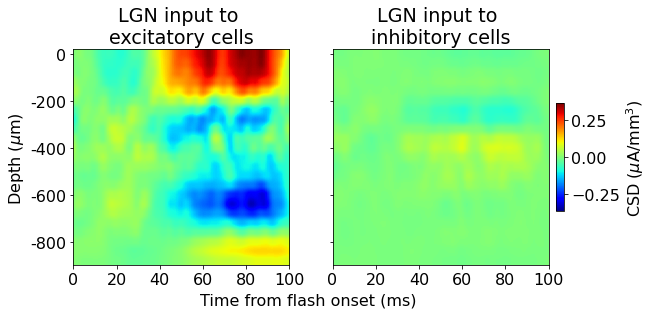

In [34]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11, 5))

fig.subplots_adjust(hspace = 0.1, wspace = 0.2, left = 0.2, right = 0.8, bottom = 0.2, top = 0.8)

scale_to_uA = 1E-3
for isim, sim_name in enumerate(np.sort(list(csd_sims.keys()))):
    print(sim_name)
    icol = isim % 2
    
    csd_sim = csd_sims[sim_name]
    csd_plot = csd_sim['trial_avg'][:nchan_sim,tstim_onset_sim:tstim_onset_sim+101]*scale_to_uA
    
    ax = axes[icol]
    
    if isim == 0:
        cmap_range = (abs(csd_plot).max())
        ax.set_yticks(depth_ticks_sim)
        ax.set_yticklabels(depth_ticklabels_sim)
        ax.set_ylabel('Depth ($\mu$m)')
    else:
        ax.set_yticks(depth_ticks_sim)
        ax.set_yticklabels([])
    
    im = ax.imshow(csd_plot, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    ax.set_xticks(time_ticks_sim)
    ax.set_xticklabels(time_ticklabels_sim)
    
    ax.set_xlim([0,100])
    
    title = sims_labels[sim_name]
    ax.set_title(title)
    
    #fig.suptitle('LGN + feedback input to all cells')
    
        
cbaxes = fig.add_axes([0.81, 0.35, 0.01, 0.3])
cb = fig.colorbar(im, ax = ax, cax = cbaxes); 
cb.set_label('CSD ($\mu$A/mm$^3$)', fontsize = '16')

#plt.figtext(s = 'Time from flash onset (ms)', x = 0.36, y = 0.09)



fig_name = 'CSD_sim_'+sim_name+'.png'
savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'white')

#### Make plots of contributions from feedback input to excitatory and inhibitory V1 neurons

In [36]:
csd_sims = dict()
for sim_name in list(csd_sims_all.keys()):
    if 'FB' in sim_name:
        csd_sims[sim_name] = csd_sims_all[sim_name]
print('Total CSD from simulations', list(csd_sims.keys()), 'retained.')

Total CSD from simulations ['FB_to_inh_cells', 'FB_to_exc_cells'] retained.


FB_to_exc_cells
FB_to_inh_cells


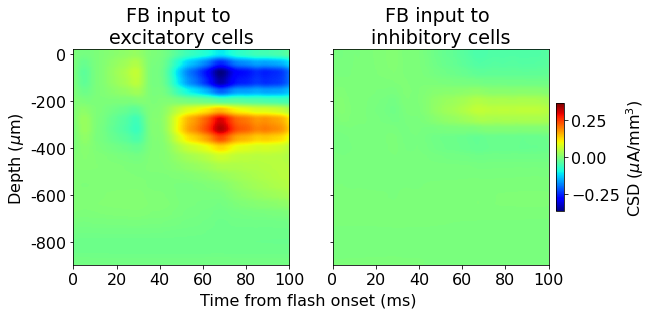

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11, 5))

fig.subplots_adjust(hspace = 0.1, wspace = 0.2, left = 0.2, right = 0.8, bottom = 0.2, top = 0.8)

scale_to_uA = 1E-3
for isim, sim_name in enumerate(np.sort(list(csd_sims.keys()))):
    print(sim_name)
    icol = isim % 2
    
    csd_sim = csd_sims[sim_name]
    csd_plot = csd_sim['trial_avg'][:nchan_sim,tstim_onset_sim:tstim_onset_sim+101]*scale_to_uA
    
    ax = axes[icol]
    
    if isim == 0:
        cmap_range = (abs(csd_plot).max())
        ax.set_yticks(depth_ticks_sim)
        ax.set_yticklabels(depth_ticklabels_sim)
        ax.set_ylabel('Depth ($\mu$m)')
    else:
        ax.set_yticks(depth_ticks_sim)
        ax.set_yticklabels([])
    
    im = ax.imshow(csd_plot, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    ax.set_xticks(time_ticks_sim)
    ax.set_xticklabels(time_ticklabels_sim)
    
    ax.set_xlim([0,100])
    
    title = sims_labels[sim_name]
    ax.set_title(title)
    
    #fig.suptitle('LGN + feedback input to all cells')
    
        
cbaxes = fig.add_axes([0.81, 0.35, 0.01, 0.3])
cb = fig.colorbar(im, ax = ax, cax = cbaxes); 
cb.set_label('CSD ($\mu$A/mm$^3$)', fontsize = '16')

plt.figtext(s = 'Time from flash onset (ms)', x = 0.36, y = 0.09)



fig_name = 'CSD_sim_'+sim_name+'.png'
savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'white')

#### Make plots of CSD from simulations with and without active channels (and no recurrent connections)

In [39]:
csd_sims = dict()
for sim_name in list(csd_sims_all.keys()):
    if 'active' in sim_name:
        csd_sims[sim_name] = csd_sims_all[sim_name]
print('Total CSD from simulations', list(csd_sims.keys()), 'retained.')

Total CSD from simulations ['with_active_channels', 'without_active_channels'] retained.


with_active_channels
without_active_channels


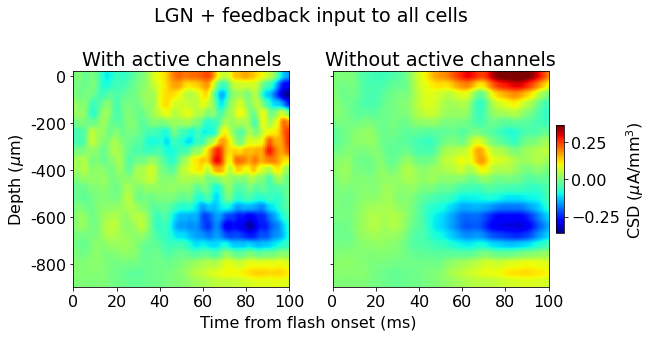

In [41]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (11, 5))

fig.subplots_adjust(hspace = 0.1, wspace = 0.2, left = 0.2, right = 0.8, bottom = 0.2, top = 0.8)

scale_to_uA = 1E-3
for isim, sim_name in enumerate(np.sort(list(csd_sims.keys()))):
    print(sim_name)
    icol = isim % 2
    
    csd_sim = csd_sims[sim_name]
    csd_plot = csd_sim['trial_avg'][:nchan_sim,tstim_onset_sim:tstim_onset_sim+101]*scale_to_uA
    
    ax = axes[icol]
    
    if isim == 0:
        cmap_range = (abs(csd_plot).max())
        ax.set_yticks(depth_ticks_sim)
        ax.set_yticklabels(depth_ticklabels_sim)
        ax.set_ylabel('Depth ($\mu$m)')
    else:
        ax.set_yticks(depth_ticks_sim)
        ax.set_yticklabels([])
    
    im = ax.imshow(csd_plot, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    ax.set_xticks(time_ticks_sim)
    ax.set_xticklabels(time_ticklabels_sim)
    
    ax.set_xlim([0,100])
    
    title = sims_labels[sim_name]
    ax.set_title(title)
    
    
    
    
fig.suptitle('LGN + feedback input to all cells')
    
        
cbaxes = fig.add_axes([0.81, 0.35, 0.01, 0.3])
cb = fig.colorbar(im, ax = ax, cax = cbaxes); 
cb.set_label('CSD ($\mu$A/mm$^3$)', fontsize = '16')

plt.figtext(s = 'Time from flash onset (ms)', x = 0.36, y = 0.09)



fig_name = 'CSD_sim_'+sim_name+'.png'
savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'white')

#### Plot total CSD from simulation with inhibitory synapses removed

In [47]:
csd_sims = dict()
for sim_name in list(csd_sims_all.keys()):
    if 'removed' in sim_name:
        csd_sims[sim_name] = csd_sims_all[sim_name]
print('Total CSD from simulations', list(csd_sims.keys()), 'retained.')

Total CSD from simulations ['inh_synapses_removed'] retained.


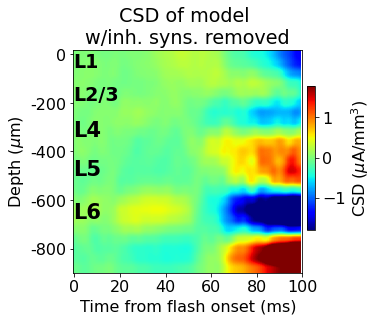

In [50]:
scale_to_uA = 1E-3

fig, ax = plt.subplots(1,1, figsize = (6,5))

fig.subplots_adjust(hspace = 0.4, wspace = 0.1, left = 0.2, right = 0.73, top = 0.8, bottom = 0.18)

        
csd_sim = csd_sims[sim_name]
csd_plot = csd_sim['trial_avg'][:nchan_sim,tstim_onset_sim:tstim_onset_sim+100]*scale_to_uA

ax.set_yticks(depth_ticks_sim)

ax.set_yticklabels(depth_ticklabels_sim)
ax.set_ylabel('Depth ($\mu$m)')
cmap_range = np.abs(csd_plot).max()/2.2

im = ax.imshow(csd_plot, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)

ax.set_xticks(time_ticks_sim)
ax.set_xticklabels(time_ticklabels_sim)
ax.set_xlabel('Time from flash onset (ms)')


title = sims_labels[sim_name]
ax.set_title('CSD of model \n'+title.lower())

cbaxes = fig.add_axes([0.74, 0.3, 0.02, 0.4])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')


plt.figtext(x = 0.2, y = 0.75, s = 'L1', fontsize = 19, fontweight = 560)
plt.figtext(x = 0.2, y = 0.66, s = 'L2/3', fontsize = 19, fontweight = 560)
plt.figtext(x = 0.2, y = 0.56, s = 'L4', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.2, y = 0.45, s = 'L5', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.2, y = 0.33, s = 'L6', fontsize = 21, fontweight = 560)


filename = 'sim_CSD_'+sim_name+'.png'

savepath = os.path.join(fig_dir, filename)

#fig.savefig(savepath, facecolor = 'w')

### Plot population contributions to the CSD

In [83]:
pop_name_labels = dict()
pop_name_labels['23e'] = 'E2/3'
pop_name_labels['23i'] = 'I2/3'
pop_name_labels['4e'] = 'E4'
pop_name_labels['4i'] = 'I4'

pop_name_labels['5e'] = 'E5'
pop_name_labels['5i'] = 'I5'
pop_name_labels['6e'] = 'E6'
pop_name_labels['6i'] = 'I6'


#### Plot population contributions for final model

In [82]:
csd_sims_layerpops = dict()
for sim_name in list(csd_sims_layerpops_all.keys()):
    if 'final' in sim_name:
        csd_sims_layerpops[sim_name] = csd_sims_layerpops_all[sim_name]
print('Total CSD from simulations', list(csd_sims_layerpops.keys()), 'retained.')

Total CSD from simulations ['final_model'] retained.


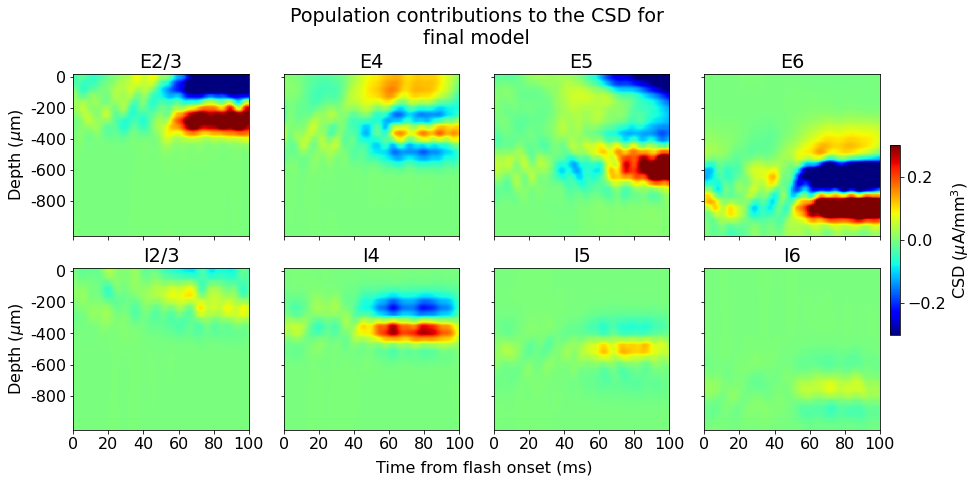

In [85]:

scale_to_uA = 1E-3

cmap_range = 0.3

for sim_name, csd_sim_layerpops in sorted(csd_sims_layerpops.items()):
    #if '12' not in sim_name:
    #    continue
    
    fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(14,6.6), sharex = True, sharey = True)

    fig.subplots_adjust(wspace = 0.2, left = 0.1, right = 0.9, bottom = 0.1, top = 0.85)
    ipop = 0
    for pop_name, csd_sim_layerpop in csd_sim_layerpops.items():
        if pop_name == '1i':
            continue
        irow = ipop // 4
        icol = ipop % 4
        csd_sim_layerpop_trial_avg = np.mean(csd_sim_layerpop, axis = 0)*scale_to_uA
        csd_plot = csd_sim_layerpop_trial_avg[:, tstim_onset_sim:tstim_onset_sim+105]
        
        #cmap_range = np.abs(csd_plot).max()
        
        im = axes[irow,icol].imshow(csd_plot, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
        
        axes[irow,icol].set_title(pop_name_labels[pop_name])
        
        ipop += 1     

    axes[0,0].set_yticks(depth_ticks_sim)
    axes[0,0].set_yticklabels(depth_ticklabels_sim)
    
    axes[0,0].set_xlim([0, 100])

    axes[0,0].set_ylabel('Depth ($\mu$m)')
    axes[1,0].set_ylabel('Depth ($\mu$m)')
    
    axes[0,0].set_xticks(time_ticks_sim)
    axes[0,0].set_xticklabels(time_ticklabels_sim)
    
    cbaxes = fig.add_axes([0.91, 0.3, 0.01, 0.4])
    cb = fig.colorbar(im, ax = axes[-1,-1], cax = cbaxes)
    cb.set_label('CSD ($\mu$A/mm$^3$)')
    
    fig.suptitle('Population contributions to the CSD for\n'+sims_labels[sim_name].lower(), y = 0.99)
    
    plt.figtext(s = 'Time from flash onset (ms)', x = 0.4, y = 0.01)
    
    #title = sims_labels[sim_name]
    #title = sim_name
    #fig.suptitle(title, y = 0.9)
    
    fig_name = 'csd_pops_'+sim_name+'-v2.png'
    
    savepath = os.path.join(fig_dir, fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

#### Plot population contributions from simulation with inhibitory synapses removed

In [86]:
csd_sims_layerpops = dict()
for sim_name in list(csd_sims_layerpops_all.keys()):
    if 'removed' in sim_name:
        csd_sims_layerpops[sim_name] = csd_sims_layerpops_all[sim_name]
print('Total CSD from simulations', list(csd_sims_layerpops.keys()), 'retained.')

Total CSD from simulations ['inh_synapses_removed'] retained.


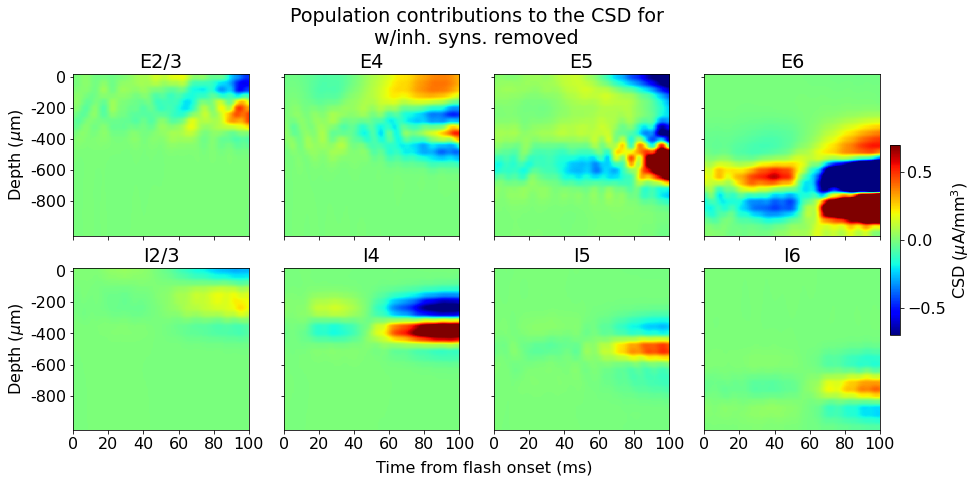

In [89]:

scale_to_uA = 1E-3

cmap_range = 0.7

for sim_name, csd_sim_layerpops in sorted(csd_sims_layerpops.items()):
    #if '12' not in sim_name:
    #    continue
    
    fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(14,6.6), sharex = True, sharey = True)

    fig.subplots_adjust(wspace = 0.2, left = 0.1, right = 0.9, bottom = 0.1, top = 0.85)
    ipop = 0
    for pop_name, csd_sim_layerpop in csd_sim_layerpops.items():
        if pop_name == '1i':
            continue
        irow = ipop // 4
        icol = ipop % 4
        csd_sim_layerpop_trial_avg = np.mean(csd_sim_layerpop, axis = 0)*scale_to_uA
        csd_plot = csd_sim_layerpop_trial_avg[:, tstim_onset_sim:tstim_onset_sim+105]
        
        #cmap_range = np.abs(csd_plot).max()
        
        im = axes[irow,icol].imshow(csd_plot, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
        
        axes[irow,icol].set_title(pop_name_labels[pop_name])
        
        ipop += 1     

    axes[0,0].set_yticks(depth_ticks_sim)
    axes[0,0].set_yticklabels(depth_ticklabels_sim)
    
    axes[0,0].set_xlim([0, 100])

    axes[0,0].set_ylabel('Depth ($\mu$m)')
    axes[1,0].set_ylabel('Depth ($\mu$m)')
    
    axes[0,0].set_xticks(time_ticks_sim)
    axes[0,0].set_xticklabels(time_ticklabels_sim)
    
    cbaxes = fig.add_axes([0.91, 0.3, 0.01, 0.4])
    cb = fig.colorbar(im, ax = axes[-1,-1], cax = cbaxes)
    cb.set_label('CSD ($\mu$A/mm$^3$)')
    
    fig.suptitle('Population contributions to the CSD for\n'+sims_labels[sim_name].lower(), y = 0.99)
    
    plt.figtext(s = 'Time from flash onset (ms)', x = 0.4, y = 0.01)
    
    #title = sims_labels[sim_name]
    #title = sim_name
    #fig.suptitle(title, y = 0.9)
    
    fig_name = 'csd_pops_'+sim_name+'.png'
    
    savepath = os.path.join(fig_dir, fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

### Spikes

In [123]:
sims_spike_trains_cell_pops = dict()

In [124]:

for sim_name in sorted(list(timestamps_configs.keys())):
    print(sim_name)

    timestamps_all_cell_pops = timestamps_configs[sim_name]
    cell_names = list(timestamps_all_cell_pops.keys())


    sim_spike_trains_cell_pops = dict()

    for cell_name in cell_names:
        print(cell_name)
        timestamps_cell_pop = timestamps_all_cell_pops[cell_name]

        neuron_ids = timestamps_cell_pop['neuron_ids_of_timestamps']
        trials = timestamps_cell_pop['trials']
        timestamps = timestamps_cell_pop['timestamps']
        #timestamps = timestamps_cell_pop['timestamps_by_trial']
        trial_dur_sim = timestamps_cell_pop['trial_dur']
        #ntrials_sim = len(np.unique(trials))
        '''TODO: Implement general way to determine # of trials (that also works for sims that lasted a bit too long)'''
        ntrials_sim = 10
        timestamps = timestamps % trial_dur_sim
        all_neuron_ids = timestamps_cell_pop['all_neuron_ids_in_pop']

        spike_trains = np.zeros((len(all_neuron_ids), ntrials_sim, trial_dur_sim))
        bins = np.arange(0,trial_dur_sim+1,1)

        for i_nrn, neuron_id in enumerate(all_neuron_ids):
            mask_neuron_id = neuron_ids == neuron_id

            timestamps_nrn = timestamps[mask_neuron_id]

            trials_this_nrn = trials[mask_neuron_id]

            for trial in np.unique(trials_this_nrn):
                if trial >= ntrials_sim:
                    continue
                mask_trial = trials_this_nrn == trial
                timestamps_nrn_this_trial = timestamps_nrn[mask_trial]
                spike_train_trial, _ = np.histogram(timestamps_nrn_this_trial, bins)

                spike_trains[i_nrn, int(trial)] = spike_train_trial

        sim_spike_trains_cell_pops[cell_name] = spike_trains[:,:ntrials_sim]
        
    sims_spike_trains_cell_pops[sim_name] = sim_spike_trains_cell_pops

inh_synapses_removed
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
old_model
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
red_E-PV_weights
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


In [125]:
sims_spike_trains_layer_pops = dict()

for sim_name in sims_spike_trains_cell_pops.keys():

    sim_spike_trains_layer_pops = dict()

    sim_spike_trains_layer_pops['RS L2/3'] = []
    sim_spike_trains_layer_pops['RS L4'] = []
    sim_spike_trains_layer_pops['RS L5'] = []
    sim_spike_trains_layer_pops['RS L6'] = []
    sim_spike_trains_layer_pops['FS'] = []

    for cell_pop_name, sim_spike_trains_cell_pop in sims_spike_trains_cell_pops[sim_name].items():
        print(cell_pop_name)#, sim_spike_trains_cell_pops[cell_pop_name].shape)
        #if cell_pop_name[0] == 'e' and cell_pop_name[1] == '2':
        if cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '2':
            if len(sim_spike_trains_layer_pops['RS L2/3']) == 0:
                sim_spike_trains_layer_pops['RS L2/3'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L2/3'] = np.concatenate((sim_spike_trains_layer_pops['RS L2/3'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        #elif cell_pop_name[0] == 'e' and cell_pop_name[1] == '4':
        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '4':
            if len(sim_spike_trains_layer_pops['RS L4']) == 0:
                sim_spike_trains_layer_pops['RS L4'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L4'] = np.concatenate((sim_spike_trains_layer_pops['RS L4'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '5':
            if len(sim_spike_trains_layer_pops['RS L5']) == 0:
                sim_spike_trains_layer_pops['RS L5'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L5'] = np.concatenate((sim_spike_trains_layer_pops['RS L5'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '6':
            if len(sim_spike_trains_layer_pops['RS L6']) == 0:
                sim_spike_trains_layer_pops['RS L6'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L6'] = np.concatenate((sim_spike_trains_layer_pops['RS L6'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] == 'Pvalb':
            if len(sim_spike_trains_layer_pops['FS']) == 0:
                sim_spike_trains_layer_pops['FS'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['FS'] = np.concatenate((sim_spike_trains_layer_pops['FS'], 
                                                               sim_spike_trains_cell_pop), axis = 0)
                
                
    sims_spike_trains_layer_pops[sim_name] = sim_spike_trains_layer_pops

e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


### Plot firing rates

In [102]:
loadpaths_unit_depths = sorted(glob(os.path.join(exp_meta_data_dir, 'units_cortical_depth', '*')))

In [103]:

sessions_units_depth = dict()


for file_path in loadpaths_unit_depths:
    properties = dict()
    
    session_id = file_path.split('/')[-1].split('_')[-1].split('.')[0]
    units_depth = pd.read_csv(file_path, sep=' ')
    units_depth = units_depth.set_index('id')
    
    properties['layer'] = units_depth['cortical_layer']
    properties['depth'] = units_depth['cortical_depth']
    
    sessions_units_depth[session_id] = properties

#### Split into layers (but merge inhibitory cells)

In [104]:
sessions_spike_trains_layer_pops = dict()
#for session_id in sessions_units_dist_top_channel.keys():
for session_id, units_depth in sessions_units_depth.items():
    #units_dist_top_channel = sessions_units_dist_top_channel[session_id]
    session_id = int(session_id)
    
    spike_trains_E23 = []
    spike_trains_E4 = []
    spike_trains_E5 = []
    spike_trains_E6 = []
    
    spike_trains_I = []
    
    
    if session_id in sessions_spike_trains_V1.keys():
        for unit_type in sessions_spike_trains_V1[session_id].keys():
            spike_trains = sessions_spike_trains_V1[session_id][unit_type]

            for i_unit, unit_id in enumerate(spike_trains.unit_id.values):
                spike_train = spike_trains[:,:,i_unit]
                #unit_dist_top_channel = units_dist_top_channel[unit_id]
                layer_label = units_depth['layer'][unit_id]

                if layer_label == 2:
                    # L23
                    if unit_type == 'exc':
                        spike_trains_E23.append(spike_train.values)
                elif layer_label == 4:
                    if unit_type == 'exc':
                        spike_trains_E4.append(spike_train.values)
                elif layer_label == 5:
                    if unit_type == 'exc':
                        spike_trains_E5.append(spike_train.values)
                elif layer_label == 6:
                    if unit_type == 'exc':
                        spike_trains_E6.append(spike_train.values)
                        
                if unit_type == 'inh':
                    spike_trains_I.append(spike_train.values)

        spike_trains_layer_pops = dict()

        spike_trains_layer_pops['RS L2/3'] = np.array(spike_trains_E23)
        spike_trains_layer_pops['RS L4'] = np.array(spike_trains_E4)
        spike_trains_layer_pops['RS L5'] = np.array(spike_trains_E5)
        spike_trains_layer_pops['RS L6'] = np.array(spike_trains_E6)
        spike_trains_layer_pops['FS'] = np.array(spike_trains_I)

        sessions_spike_trains_layer_pops[session_id] = spike_trains_layer_pops
        

In [105]:
all_spike_trains_layer_pops = dict()

all_spike_trains_layer_pops['RS L2/3'] = []
all_spike_trains_layer_pops['RS L4'] = []
all_spike_trains_layer_pops['RS L5'] = []
all_spike_trains_layer_pops['RS L6'] = []
all_spike_trains_layer_pops['FS'] = []

sessions_ncells_layer_pops = dict()

for session_id, spike_trains_layer_pops in sessions_spike_trains_layer_pops.items():
    ncells_layer_pops = dict()
    for pop_name, spike_trains in spike_trains_layer_pops.items():
        
        ncells_layer_pops[pop_name] = len(spike_trains)
        
        if len(spike_trains) == 0:
            continue
        elif len(all_spike_trains_layer_pops[pop_name]) == 0:
            print(pop_name)
            all_spike_trains_layer_pops[pop_name] = spike_trains
        else:
            all_spike_trains_layer_pops[pop_name] = np.concatenate([all_spike_trains_layer_pops[pop_name], \
                                                                   spike_trains])
            
    sessions_ncells_layer_pops[session_id] = ncells_layer_pops

RS L2/3
RS L4
RS L5
RS L6
FS


red_E-PV_weights


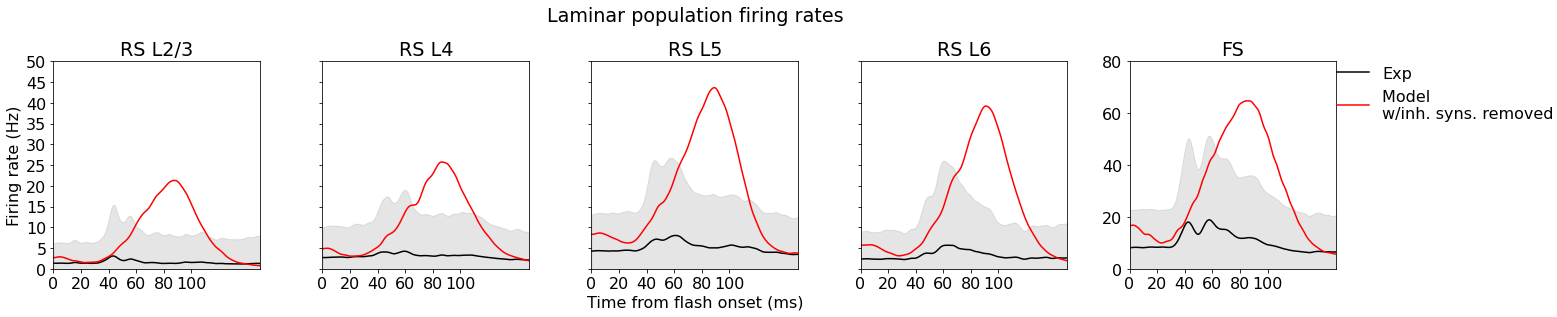

In [126]:
tstim_onset = 1000

fig, axes = plt.subplots(ncols = 5, figsize = (22,4.5))

fig.subplots_adjust(wspace = 0.3, left = 0.04, right = 0.85, bottom = 0.18, top = 0.82)

sim_names = list(sims_spike_trains_layer_pops.keys())
sim_names.insert(0, sim_names.pop())

iplot = 0
for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
    
    if iplot == 4:
        axes[iplot].set_ylim([0, 80])
    else:
        axes[iplot].set_ylim([0, 50])
        if iplot == 0:
            
            fir_rate_label = 'Exp'
            std_label = '±1$\sigma$'
            
            axes[iplot].set_yticks(np.arange(0,50+5,5))
            axes[iplot].set_yticklabels(np.arange(0,50+5,5))
        else:
            fir_rate_label = None
            std_label = None
            sim_labels = [None, None]
            axes[iplot].set_yticks(np.arange(0,50+5,5))
            axes[iplot].set_yticklabels([])
    
    pop_fir_rate = np.mean(np.mean(all_spike_trains_pop, axis = 0), axis = 0) * 1E3
    
    #all_spike_trains_pop_rs = all_spike_trains_pop.reshape(all_spike_trains_pop.shape[0]*\
    #                                                       all_spike_trains_pop.shape[1],-1)
    
    fir_rate_trial_avg = np.mean(all_spike_trains_pop, axis = 1)
    
    #std_time_resolved =  np.std(all_spike_trains_pop_rs, axis = 0)[tstim_onset:tstim_onset+100]*1E3
    
    std_of_trial_avg =  np.std(fir_rate_trial_avg, axis = 0)[tstim_onset:tstim_onset+155]*1E3
    
    std_of_trial_avg = gaussian_filter(std_of_trial_avg, sigma = 2)

    
    
    fir_rate_plot = gaussian_filter(pop_fir_rate, sigma = 2)[tstim_onset:tstim_onset+155]
    
    time = np.arange(0, 155, 1)
    
    axes[iplot].plot(time, fir_rate_plot, color = 'k', label = fir_rate_label)
    
    axes[iplot].fill_between(x = time, y1 = fir_rate_plot-std_of_trial_avg, \
                             y2 = fir_rate_plot+std_of_trial_avg, color = (0.5,0.5,0.5), 
                             alpha = 0.2)
    
    for isim, sim_name in enumerate(sim_names[::-1]):
        
        if 'removed' in sim_name:
            sim_spike_trains_layer_pop = sims_spike_trains_layer_pops[sim_name][pop_name]

            sim_pop_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop[:, :10, \
                                        tstim_onset_sim:tstim_onset_sim+155], axis = 0), axis = 0)*1E3

            sim_fir_rate_plot = gaussian_filter(sim_pop_fir_rate, sigma = 2)

            if iplot == 0:
                sim_label = 'Model \n'+str(sims_labels[sim_name])
                #sim_label = sim_name
            else:
                sim_label = None

            axes[iplot].plot(time, sim_fir_rate_plot, color = sims_colors[sim_name], label = sim_label)
            #axes[iplot].plot(time, sim_fir_rate_plot, label = sim_label)

    
    
            
    axes[iplot].set_xticks(np.arange(0,100+20,20))
    axes[iplot].set_xticklabels(np.arange(0,100+20,20))
    
    axes[iplot].set_xlim([0,150])
    
    axes[iplot].set_title(pop_name)
    iplot += 1
    
axes[0].set_ylabel('Firing rate (Hz)')

fig.suptitle('Laminar population firing rates', y = 0.99, x = 0.445)
    
#plt.figtext(s = 'Time from flash onset (ms)', x = 0.43, y = 0.05)
axes[2].set_xlabel('Time from flash onset (ms)')
    
fig.legend(bbox_to_anchor = (0.99, 0.82), frameon = False)
print(sim_name)
fig_name = 'exp_and_sim_pop_fir_rate_'+sim_name+'.png'

savepath = os.path.join('Figures', 'supplementary_figures', fig_name)

#fig.savefig(savepath, facecolor = 'w')

red_E-PV_weights


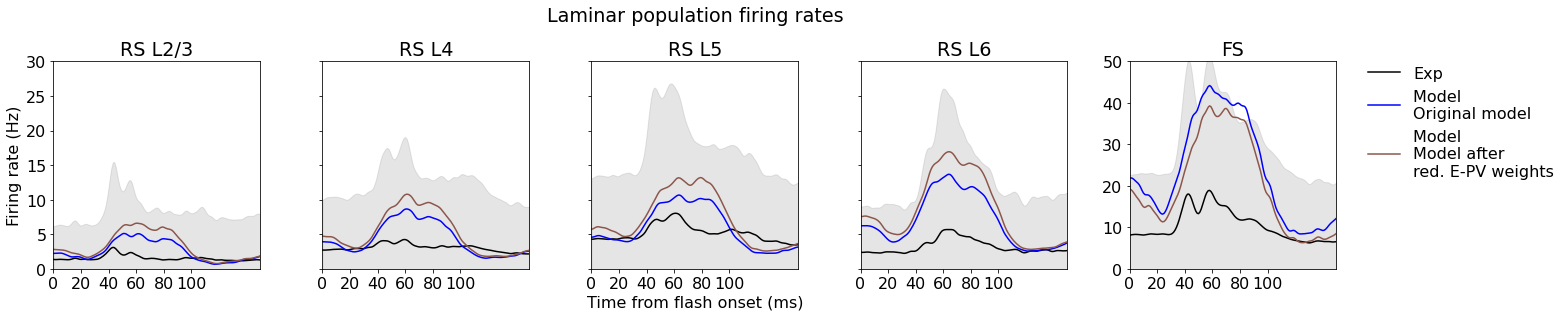

In [130]:
tstim_onset = 1000

fig, axes = plt.subplots(ncols = 5, figsize = (22,4.5))

fig.subplots_adjust(wspace = 0.3, left = 0.04, right = 0.85, bottom = 0.18, top = 0.82)

sim_names = list(sims_spike_trains_layer_pops.keys())
sim_names.insert(0, sim_names.pop())

iplot = 0
for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
    
    if iplot == 4:
        axes[iplot].set_ylim([0, 50])
    else:
        axes[iplot].set_ylim([0, 30])
        if iplot == 0:
            
            fir_rate_label = 'Exp'
            std_label = '±1$\sigma$'
            
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels(np.arange(0,30+5,5))
        else:
            fir_rate_label = None
            std_label = None
            sim_labels = [None, None]
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels([])
    
    pop_fir_rate = np.mean(np.mean(all_spike_trains_pop, axis = 0), axis = 0) * 1E3
    
    #all_spike_trains_pop_rs = all_spike_trains_pop.reshape(all_spike_trains_pop.shape[0]*\
    #                                                       all_spike_trains_pop.shape[1],-1)
    
    fir_rate_trial_avg = np.mean(all_spike_trains_pop, axis = 1)
    
    #std_time_resolved =  np.std(all_spike_trains_pop_rs, axis = 0)[tstim_onset:tstim_onset+100]*1E3
    
    std_of_trial_avg =  np.std(fir_rate_trial_avg, axis = 0)[tstim_onset:tstim_onset+155]*1E3
    
    std_of_trial_avg = gaussian_filter(std_of_trial_avg, sigma = 2)

    
    
    fir_rate_plot = gaussian_filter(pop_fir_rate, sigma = 2)[tstim_onset:tstim_onset+155]
    
    time = np.arange(0, 155, 1)
    
    axes[iplot].plot(time, fir_rate_plot, color = 'k', label = fir_rate_label)
    
    axes[iplot].fill_between(x = time, y1 = fir_rate_plot-std_of_trial_avg, \
                             y2 = fir_rate_plot+std_of_trial_avg, color = (0.5,0.5,0.5), 
                             alpha = 0.2)
    
    for isim, sim_name in enumerate(sim_names[::-1]):
        
        if 'removed' in sim_name:
            continue
        sim_spike_trains_layer_pop = sims_spike_trains_layer_pops[sim_name][pop_name]

        sim_pop_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop[:, :10, \
                                    tstim_onset_sim:tstim_onset_sim+155], axis = 0), axis = 0)*1E3

        sim_fir_rate_plot = gaussian_filter(sim_pop_fir_rate, sigma = 2)

        if iplot == 0:
            sim_label = 'Model \n'+str(sims_labels[sim_name])
            #sim_label = sim_name
        else:
            sim_label = None

        axes[iplot].plot(time, sim_fir_rate_plot, color = sims_colors[sim_name], label = sim_label)
        #axes[iplot].plot(time, sim_fir_rate_plot, label = sim_label)

    
    
            
    axes[iplot].set_xticks(np.arange(0,100+20,20))
    axes[iplot].set_xticklabels(np.arange(0,100+20,20))
    
    axes[iplot].set_xlim([0,150])
    
    axes[iplot].set_title(pop_name)
    iplot += 1
    
axes[0].set_ylabel('Firing rate (Hz)')

fig.suptitle('Laminar population firing rates', y = 0.99, x = 0.445)
    
#plt.figtext(s = 'Time from flash onset (ms)', x = 0.43, y = 0.05)
axes[2].set_xlabel('Time from flash onset (ms)')
    
fig.legend(bbox_to_anchor = (0.99, 0.82), frameon = False)
print(sim_name)
fig_name = 'exp_and_sim_pop_fir_rate_'+sim_name+'.png'

savepath = os.path.join('Figures', 'supplementary_figures', fig_name)

#fig.savefig(savepath, facecolor = 'w')